## Libraries

In [1]:
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

from utils.dataset import create_model_dataset, to_temporal_dataset, load_val_test_dataset
from utils.load import read_config
from training.train import Trainer
from utils.miscellaneous import get_numerical_times, calculate_speed_ups, SpatialAnalysis, get_model
from utils.visualization import plot_breach_distribution, PlotRollout


In [2]:
def load_trained_model(config, model_name, model_dir):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset_parameters = config['dataset_parameters']
    scalers = config['scalers']
    selected_node_features = config['selected_node_features']
    selected_edge_features = config['selected_edge_features']

    train_dataset, _, _, scalers = create_model_dataset(
        'grid', scalers=scalers, device=device, **dataset_parameters,
        **selected_node_features, **selected_edge_features
    )

    temporal_dataset_parameters = config['temporal_dataset_parameters']

    temporal_train_dataset = to_temporal_dataset(train_dataset, **temporal_dataset_parameters)

    node_features, edge_features = temporal_train_dataset[0].x.size(-1), temporal_train_dataset[0].edge_attr.size(-1)
    num_nodes, num_edges = temporal_train_dataset[0].x.size(0), temporal_train_dataset[0].edge_attr.size(0)

    previous_t = temporal_dataset_parameters['previous_t']

    model_parameters = config['models']
    model_type = model_parameters.pop('model_type')

    if model_type == 'GNN':
        model_parameters['edge_features'] = edge_features
    elif model_type == 'MLP':
        model_parameters.num_nodes = num_nodes

    model = get_model(model_type)(
        node_features=node_features,
        previous_t=previous_t,
        device=device,
        **model_parameters).to(device)

    trainer_options = config['trainer_options']
    try:
        batch_size = trainer_options.pop('batch_size')
    except:
        pass

    lr_info = config['lr_info']

    # Model optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_info['step_size'], gamma=lr_info['gamma'])

    # Training (but only used to load here)
    trainer = Trainer(optimizer, lr_scheduler, **trainer_options)
    trainer._load_model(model, model_name=model_name, save_dir=model_dir)

    return model, scalers

### Plot details

To ensure readability of big plots

In [3]:
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 75
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['savefig.bbox'] = 'tight'

mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

## Dataset creation

In [4]:
# Specify type of model to be used and, consequently, its directory
model_type = 'SWEGNN'
results_dir = f'results/best_models/{model_type}'

# config contains all properties to describe datasets, training, and testing
config = read_config(f'{results_dir}/config.yaml')

# Change these lines here if you want to change the testing dataset
config['dataset_parameters']['test_size'] = 'big_random_breach' #dataset 3
config['dataset_parameters']['test_size'] = 'random_breach'     #dataset 2
# config['dataset_parameters']['test_size'] = 20                  #dataset 1

# Then you obtain a split in validation and testing datasets (here we don't care about the training one)
val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

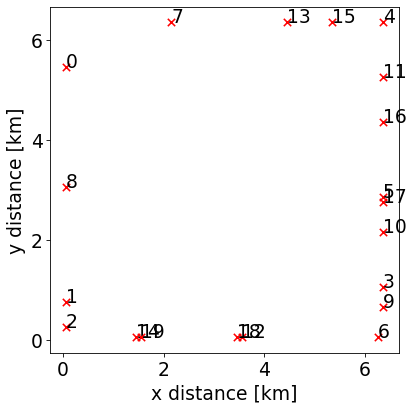

In [5]:
# Check the distribution of breaches in datasets 2 and 3
fig, ax = plt.subplots(figsize=(6,6))
plot_breach_distribution(test_dataset, ax=ax, with_label=True);

# Model

## Load trained model

This notebook is not for training the model. For training, please run main.py

In [6]:
# If you want to change model, be sure to change directory of the saved model, as the config file changes
model, scalers = load_trained_model(config, f'{model_type}.h5', model_dir=results_dir)

## Check predictions

All predictions are saved in the object spatial_analyser, that can be used for all plotting and analyses

In [7]:
# run and store all simulations in test_dataset in this object here
spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)

In [8]:
maximum_time = test_dataset[0].WD.shape[1]
dataset_parameters = config['dataset_parameters']
test_size = dataset_parameters['test_size']
temporal_res = dataset_parameters['temporal_res']

# get simulation times for numerical model 
numerical_times = get_numerical_times(test_size, temporal_res, maximum_time, 
                **temporal_test_dataset_parameters,
                overview_file='database/raw_datasets/overview.csv')

In [9]:
# Obtain loss over the test dataset and prediction times
rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
model_times = spatial_analyser.prediction_times

print('test roll loss WD:',rollout_loss.mean(0)[0].item())
print('test roll loss V:',rollout_loss.mean(0)[1:].mean().item())

test roll loss WD: 0.11106137186288834
test roll loss V: 0.013121679425239563


In [10]:
# Determine speed-up
avg_speedup, std_speedup = calculate_speed_ups(numerical_times, model_times)
print(f'mean speed-up: {avg_speedup:.2f}\nstd speed-up: {std_speedup:.3f}')

mean speed-up: 1.95
std speed-up: 0.274


# Plots

## Dataset statistics

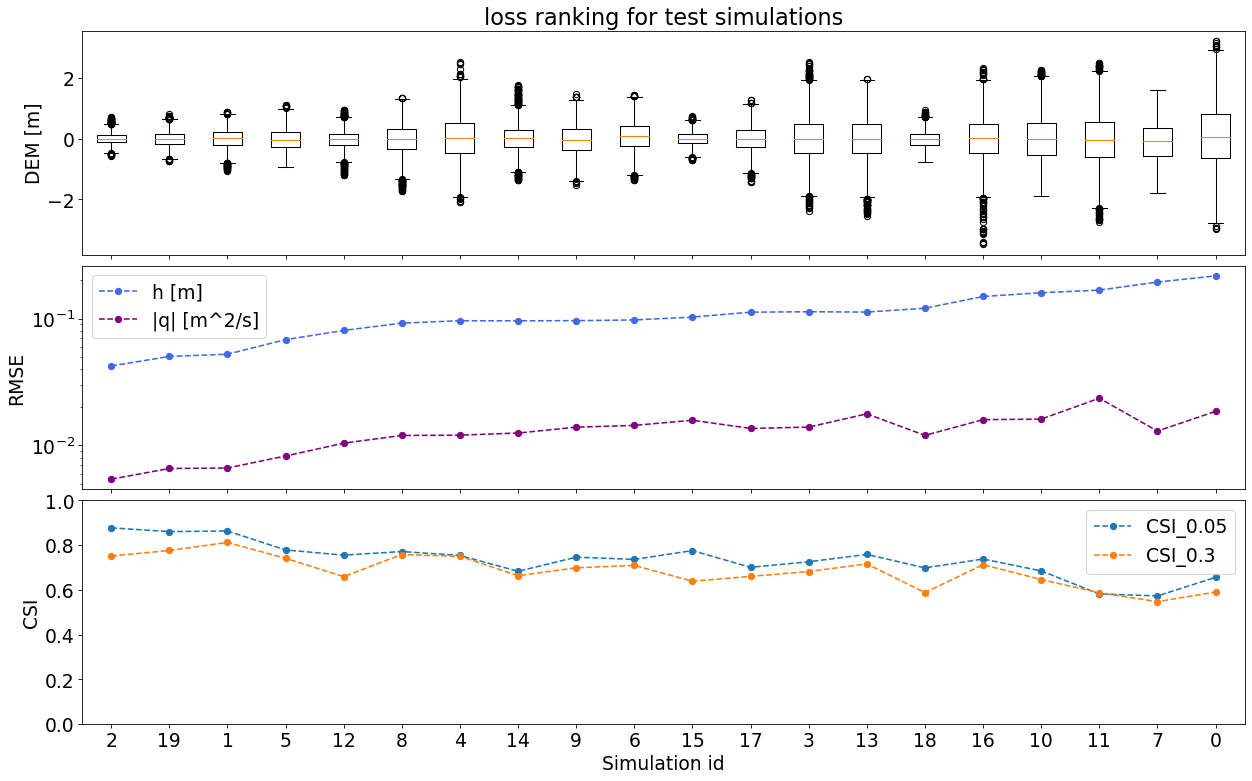

In [11]:
# Rank all simulations in a dataset either by 'loss' or 'CSI'
sorted_ids = spatial_analyser.plot_loss_per_simulation(type_loss='RMSE', ranking='loss', figsize=(20,12))

[0.73616517 0.68463475]


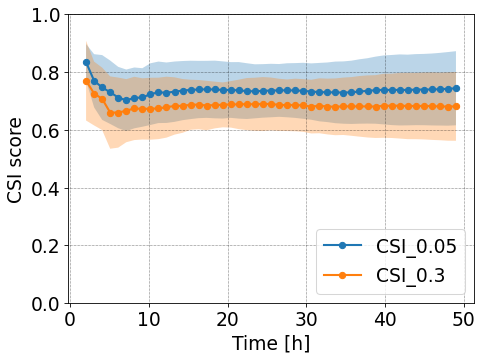

In [12]:
# CSI in time (you can also plot the F1 score in the same way)
fig, CSI = spatial_analyser.plot_CSI_rollouts(water_thresholds=[0.05, 0.3])
print(CSI.mean(1).mean(1))

# fig, F1 = spatial_analyser.plot_F1_rollouts(water_thresholds=[0.05, 0.3])
# print(F1.mean(1).mean(1))

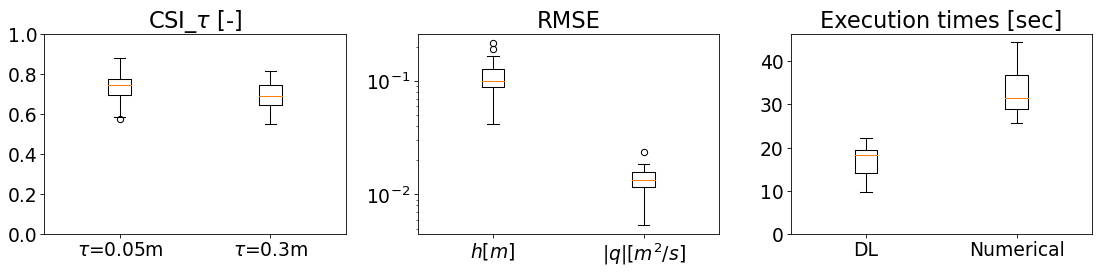

In [13]:
# Summary using bo plots
fig = spatial_analyser.plot_summary(numerical_times, figsize=(15,4))

## Single simulations

In [14]:
# Change id according to which simulation you want to run and visualize
id_dataset = 13

rollout_plotter = PlotRollout(model, test_dataset[id_dataset], scalers=scalers, 
    type_loss='RMSE', **temporal_test_dataset_parameters)

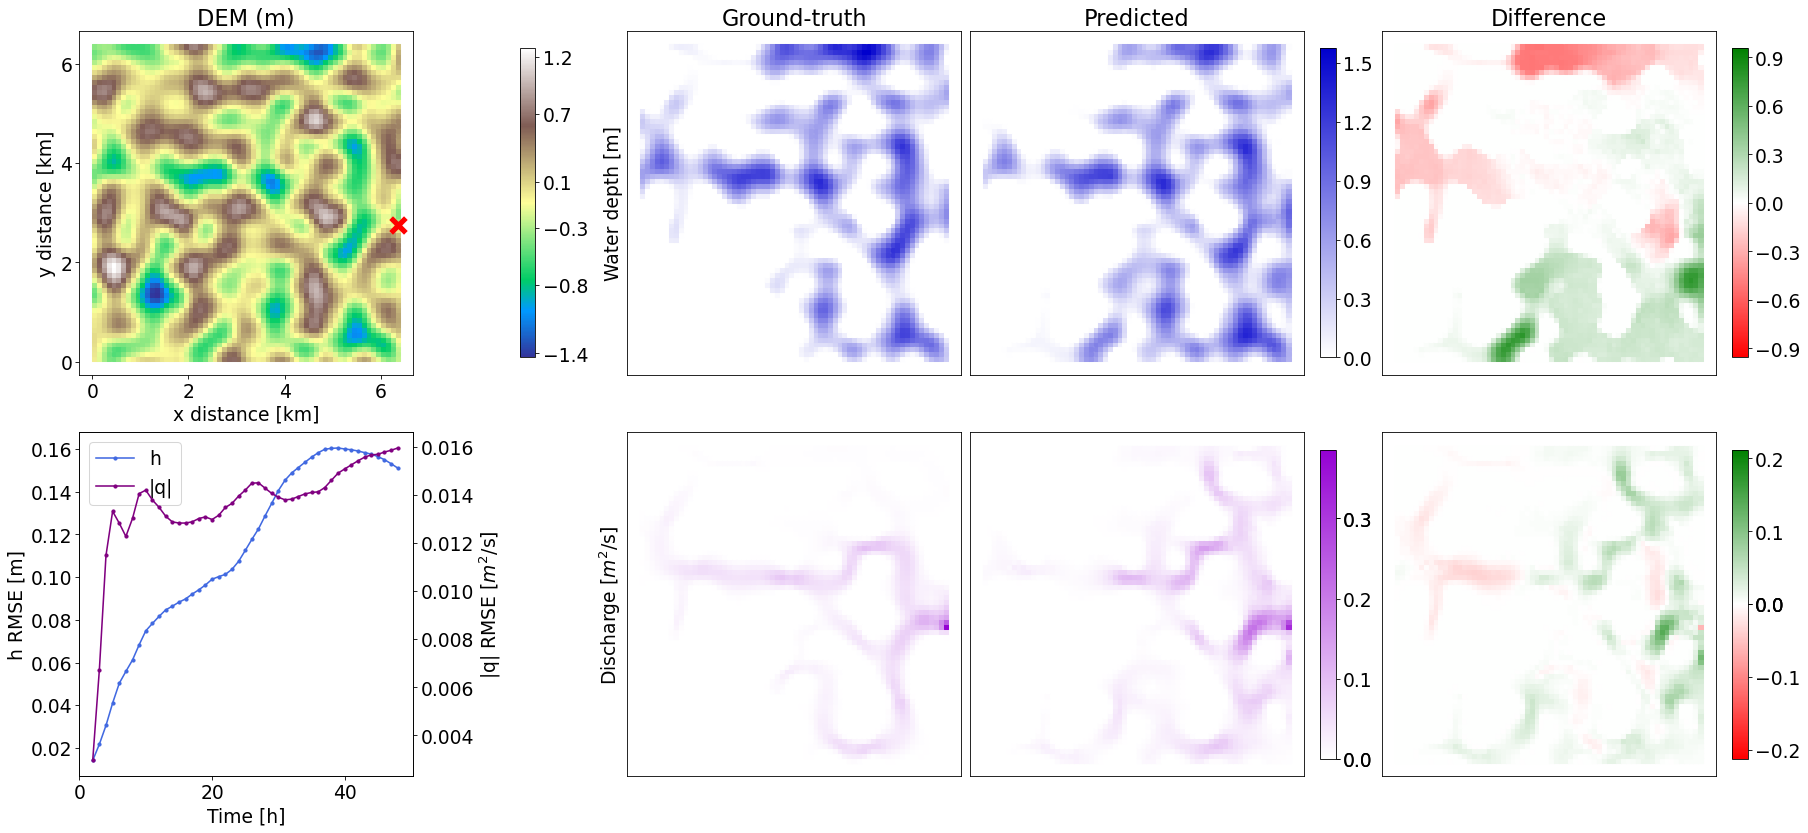

In [15]:
# summary plot
fig = rollout_plotter.explore_rollout()

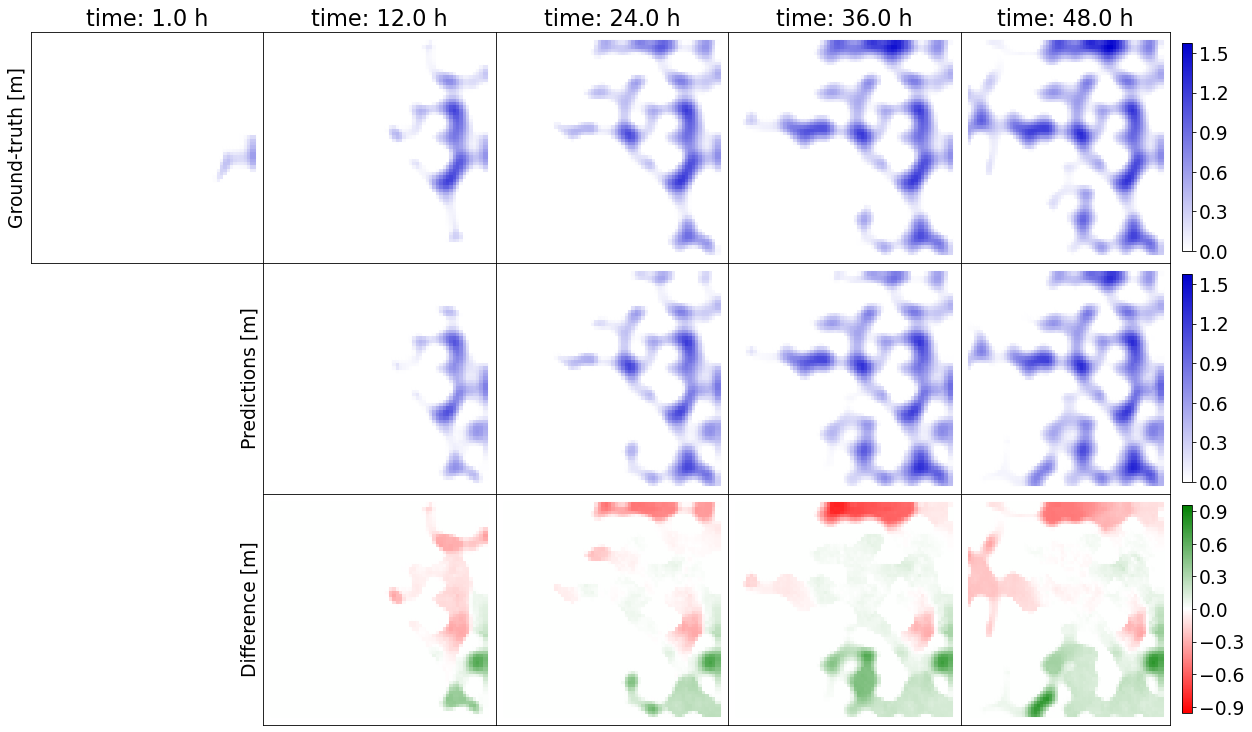

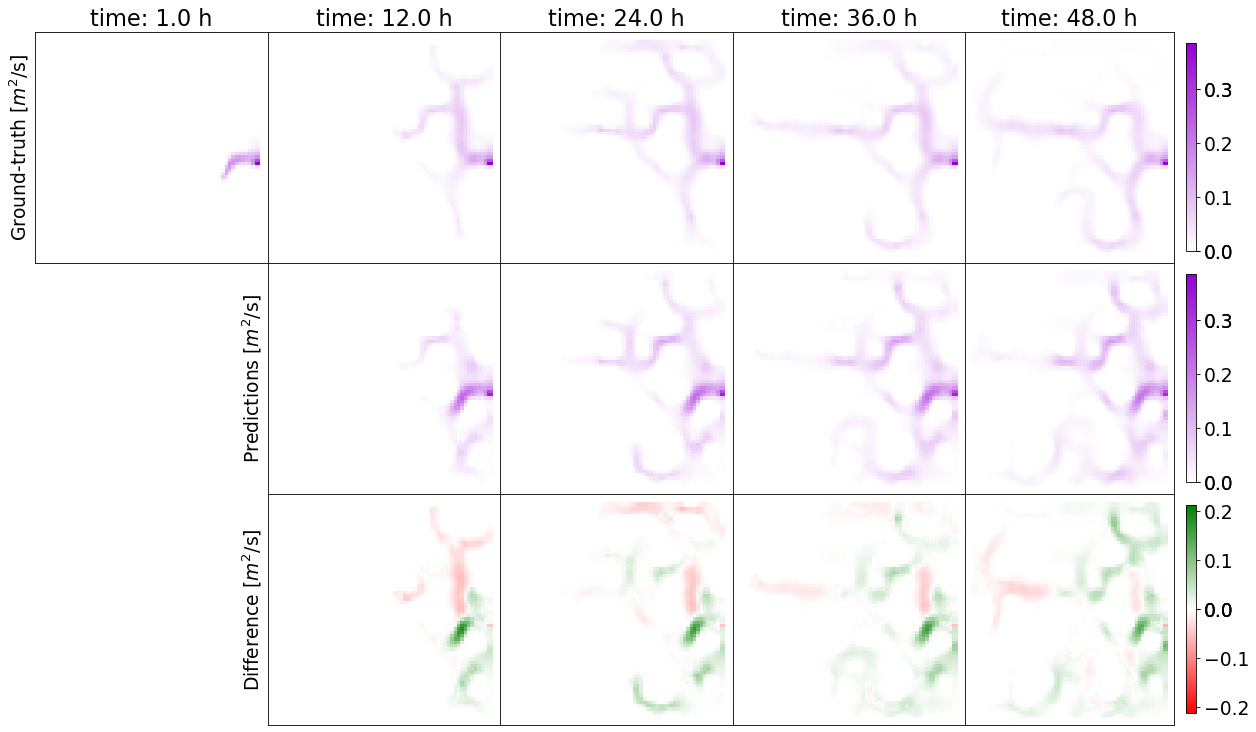

In [16]:
# Plot solution at different time steps (by default there are always input time and final time)
plot_times = [10,22,34]

# plot water depths
rollout_plotter.compare_h_rollout(plot_times)

# plot discharges
rollout_plotter.compare_v_rollout(plot_times)

### Single spatial analysis

tensor([0.1123, 0.0136])

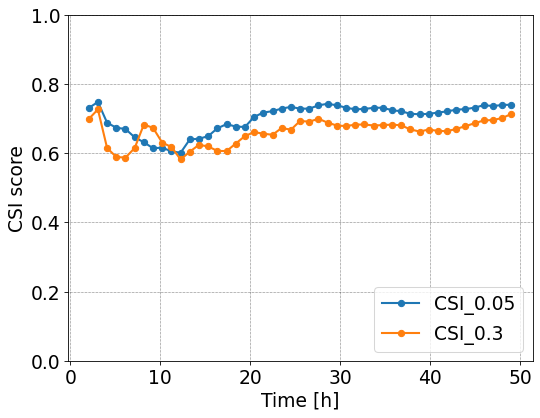

In [17]:
rollout_plotter._plot_metric('CSI')
rollout_plotter._get_rollout_loss()

### Video

In [ ]:
# Run this cell to create the video (for more information check its documentation)
rollout_plotter.create_video()
rollout_plotter.save_video(path=f'results/test_{id_dataset:02d}', fps=10)